## **AIX360(KernelExplainer)**
Import related to Kernel Explainer and for Random Forest Clasifier

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
from cciexplain.algorithms.explainer.shap import Shap
from cciexplain.models.preprocessor_cci import Preprocessor

In [13]:
df: pd.DataFrame = pd.read_csv('cciexplain/datasets/Adult.csv')
prep = Preprocessor(dataframe=df, independent_var='income')
print(prep.X)
# prep.impute_values()
prep.categorical_data_encoder(encoding='ordinal_encoder',
                              columns=[1, 3, 5, 6, 7, 8, 9,  13])



[[25 'Private' 226802 ... 0 40 'United-States']
 [38 'Private' 89814 ... 0 50 'United-States']
 [28 'Local-gov' 336951 ... 0 40 'United-States']
 ...
 [58 'Private' 151910 ... 0 40 'United-States']
 [22 'Private' 201490 ... 0 20 'United-States']
 [52 'Self-emp-inc' 287927 ... 0 40 'United-States']]


In [15]:
cat_ix = df.select_dtypes(include=['object', 'bool']).columns
print(prep.X)

prep.independent_variable_data_encoder()
print(prep.y)

feature_names = prep.feature_target(dataframe=df, column='income')
print(feature_names)

[[4.0 1.0 4.0 ... 0 0 40]
 [4.0 11.0 2.0 ... 0 0 50]
 [2.0 7.0 2.0 ... 0 0 40]
 ...
 [4.0 11.0 6.0 ... 0 0 40]
 [4.0 11.0 4.0 ... 0 0 20]
 [5.0 11.0 2.0 ... 15024 0 40]]
[0 0 1 ... 0 0 1]
(['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], ['income'])


In [16]:
X_train, X_test, y_train, y_test = prep.split_data()

In [17]:
model = LogisticRegression(multi_class='multinomial', max_iter=500,
                           random_state=0)


model.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=0)

In [18]:
start_example_idx = 0
stop_example_idx = 10
background_data = slice(start_example_idx, stop_example_idx)

In [19]:
shap_type = Shap()

shap_explainer = shap_type.blackbox.kernel_explainer(model.predict,
                                                     X_train[background_data, :])

shap_values = shap_explainer.explain_instance(X_test[background_data, :])

100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


In [22]:
shap.initjs()
shap.force_plot(shap_explainer.explainer.expected_value, shap_values,
                X_test, feature_names)


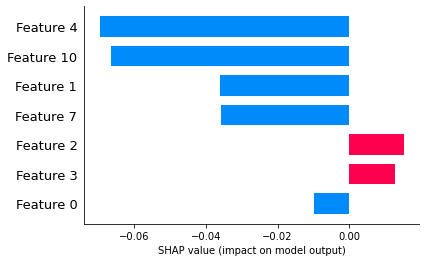

In [31]:
shap.bar_plot(shap_values[0])

## **Alibi Explain**
Import the required imports based on KernelSHAP

In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from cciexplain.algorithms.explainer.shap import Shap
from cciexplain.models.preprocessor_cci import Preprocessor
from scipy.special import logit
np.random.seed(0)

In [3]:
df: pd.DataFrame = pd.read_csv('cciexplain/datasets/wine.csv')
prep = Preprocessor(dataframe=df, independent_var='name')
data = prep.X

target = prep.y

feature_names, target_names = prep.feature_target(dataframe=df,
                                                  column='name')

category_map = prep.gen_category_map(data=df)

print(target)
print(feature_names)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
['alcohol', 'malicAcid', 'ash', 'ashalcalinity', 'magnesium', 'totalPhenols', 'flavanoids', 'nonFlavanoidPhenols', 'proanthocyanins', 'colorIntensity', 'hue', 'od280_od315', 'proline']


In [5]:
X_train, X_test, y_train, y_test = prep.split_data()

print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [6]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

classifier = LogisticRegression(multi_class='multinomial',
                                random_state=0,
                                )
classifier.fit(X_train_norm, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

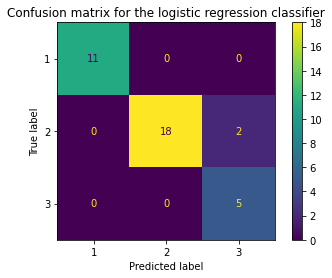

In [7]:
y_pred = classifier.predict(X_test_norm)

cm = confusion_matrix(y_test, y_pred)

title = 'Confusion matrix for the logistic regression classifier'
disp = plot_confusion_matrix(classifier,
                             X_test_norm,
                             y_test,
                             # display_labels=target_names,
                             # cmap=plt.cm.Blues,
                             normalize=None,
                             )
disp.ax_.set_title(title)
pred_fcn = classifier.predict_proba

In [8]:
shap_type = Shap(kernel='alibi')

lr_explainer = shap_type.blackbox.kernel_shap(pred_fcn, link='logit')
lr_explainer.fit(X_train_norm)

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'logit',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [9]:
# passing the logit link function to the explainer ensures the units are consistent ...
mean_scores_train = logit(pred_fcn(X_train_norm).mean(axis=0))
print(mean_scores_train - lr_explainer.expected_value)

[ 0.0000000e+00  4.4408921e-16 -4.4408921e-16]


100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


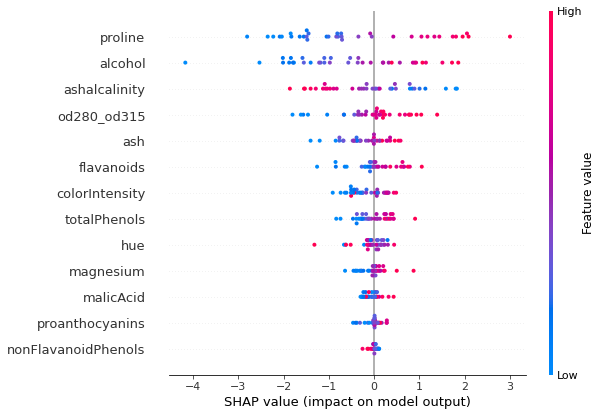

In [10]:
lr_explanation = lr_explainer.explain(X_test_norm, l1_reg=False)

shap.summary_plot(lr_explanation.shap_values[0], X_test_norm, feature_names)

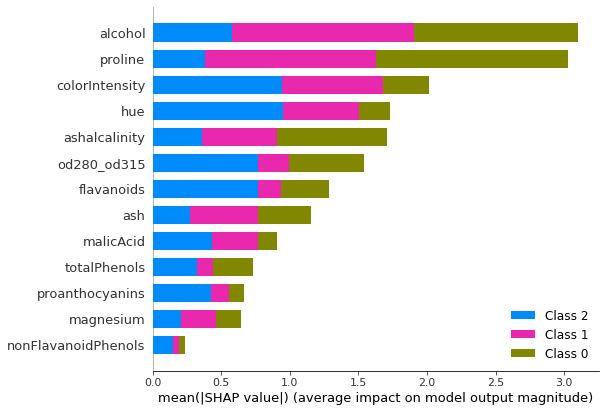

In [16]:
shap.summary_plot(lr_explanation.shap_values, X_test, feature_names,
                  plot_type='bar')

# **InterpretML**
Import related to SHAP Kernel and for Random Forest Clasifier

In [17]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from cciexplain.algorithms.explainer.shap import Shap
from cciexplain.models.preprocessor_cci import Preprocessor
from sklearn.pipeline import Pipeline
from cciexplain.common import ROC, show, RegressionPerf

In [18]:
df: pd.DataFrame = pd.read_csv('cciexplain/datasets/wine.csv')
prep = Preprocessor(dataframe=df, independent_var='name')
data = prep.X

target = prep.y

feature_names, target_names = prep.feature_target(dataframe=df,
                                                  column='name')

category_map = prep.gen_category_map(data=df)

print(target)
print(feature_names)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
['alcohol', 'malicAcid', 'ash', 'ashalcalinity', 'magnesium', 'totalPhenols', 'flavanoids', 'nonFlavanoidPhenols', 'proanthocyanins', 'colorIntensity', 'hue', 'od280_od315', 'proline']


In [19]:
X_train, X_test, y_train, y_test = prep.split_data(random_state=1)


In [20]:
# Blackbox system can include preprocessing, not just a regressor!
pca = PCA()
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [21]:
blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, y_train)

blackbox_perf = RegressionPerf(blackbox_model.predict,
                               feature_names=feature_names).explain_perf(
    X_test, y_test, name='Blackbox')
show(blackbox_perf)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


<!-- http://127.0.0.1:7001/2870939171784/ -->

In [22]:
shap_type = Shap(kernel='interpret')
background_val = np.median(X_train, axis=0).reshape(1, -1)
shap_value = shap_type.blackbox.shap_kernel_explainer(
    predict_fn=blackbox_model.predict, data=background_val,
    feature_names=feature_names)
shap_local = shap_value.explain_local(X_test[:5], y_test[:5], name='SHAP')
show(shap_local)

100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


<!-- http://127.0.0.1:7001/2870967233224/ -->

In [23]:
data_int = shap_local.data(-1)['mli'][0]['value']['scores'].mean(axis=0)

In [24]:
shap_value_abs = np.abs(data_int)

shap_mean = data_int.mean(axis=0)
print(shap_value_abs)

[5.08847698e-03 3.12658917e-02 1.91595064e-03 5.10239940e-02
 6.76213841e-02 9.77017578e-03 3.31826305e-02 6.85025073e-03
 7.60458116e-04 8.34764095e-02 2.45488741e-04 3.83594196e-03
 3.58836191e-01]


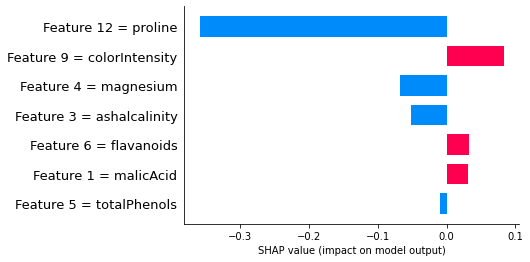

In [25]:
shap.bar_plot(data_int, feature_names)